In [62]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation # animate by repeatedly calling a function
from IPython import display # manipulate notebook output
import matplotlib.pyplot as plt
import numpy as np

# bring in the .mp4 video file and slice it into images
vidcap = cv2.VideoCapture('cars_scene_1_short.mp4')
success, image = vidcap.read()
count = 0
image_list_0 = []
while success:
    cv2.imwrite('/Users/nolanardolino/Desktop/try2/monodepth_1/vid2ims/frame%05d.jpg' % count, image) # save frame as JPEG file to a specified location      
    success,image = vidcap.read()
    image_list_0.append(image) # generate a list of images taken from the video
    #print('Read a new frame: ' success)
    count += 1

number of images:  363
sampled list size: 363
image dimensions: (720, 1280, 3)


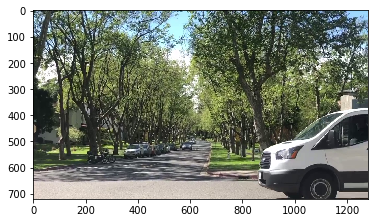

In [63]:
print('number of images: ', len(image_list_0)-1)
image_list = image_list_0#[0::10]# where x is the sampling interval
print('sampled list size:', len(image_list)-1)
print('image dimensions:', image_list[0].shape)
plt.imshow(cv2.cvtColor(image_list[21], cv2.COLOR_BGR2RGB))
plt.show()

In [64]:
from matplotlib.animation import FuncAnimation # animate by repeatedly calling a function
from IPython import display # manipulate notebook output

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

line = plt.imshow([[]], extent=(0,20,0,12))

def animate(frame):

    line.set_data(cv2.cvtColor(image_list[frame], cv2.COLOR_BGR2RGB))
    

anim = FuncAnimation(fig, animate, frames=len(image_list)-2, interval=40) # frames rounded down
video = anim.to_html5_video()
plt.close()
display.HTML(video)

In [30]:
# run bash_1 at this point

In [120]:
from PIL import Image
import glob
import os

processed_images = []

# bring in the file paths for all of the images 
# extracted from the video and processed by the tf model (files were copied to project folder via command line)
names = sorted(glob.glob('/Users/nolanardolino/Desktop/try2/monodepth_1/processed_images/*'))
len(names)
def sortKeyFunc(s):
    return int(os.path.basename(s)[5:-9]) # only look at the part of the file path that says (frame#)

names.sort(key=sortKeyFunc)

pics = {}
for n in names:
    img = Image.open(n)
    pic = img.copy()
    img.close()
    processed_images.append(pic)

In [146]:
box_top = 10
box_bottom = 1

def dot_on_image(frame, x_coord, y_coord):
    
    grayscale_value, b, c, d = processed_images[10].getpixel((x_coord, y_coord))

    #print(grayscale_value)

    threshold1 = (2/3)*255
    threshold2 = (1/3)*255

    if grayscale_value > threshold1:
        distance = 'close'
        r = 255
        g = 0
        b = 0 
        dot_color = 'r'

    elif threshold1 >= grayscale_value >= threshold2:
        distance = 'near'
        r = 0
        g = 0
        b = 255  
        dot_color = 'b'

    elif grayscale_value < threshold2:
        distance = 'far'
        r = 0
        g = 255
        b = 0  
        dot_color = 'g'

    return distance, r,g,b, dot_color
        
        
dist, r, g, b, dot_color = dot_on_image(10, 1,1)

print(dist, r, g, b, dot_color)



close 255 0 0 r


In [122]:
from matplotlib.animation import FuncAnimation # animate by repeatedly calling a function
from IPython import display # manipulate notebook output

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()

line = plt.imshow([[]], extent=(0,20,0,12))
line2 = plt.imshow([[]], extent=(0,20,0,12))

def animate(frame):

    #line.set_data(image_list[frame])
    line.set_data(processed_images[frame])
    

anim = FuncAnimation(fig, animate, frames=len(processed_images), interval=40) # frames rounded down
video = anim.to_html5_video()
plt.close()
display.HTML(video)

In [139]:
print(len(processed_images))
## Now combine this with object recognition

364


In [123]:
# Read the file in
with open('./labels1.txt', 'r') as f:
    labels = f.readlines()

# Remove the indexes
labels = list(map(lambda x: x[x.index(' '):], labels))

# Strip leading and trailing whitespace
labels = list(map(lambda x: x.strip(), labels))

print(len(labels))
print(labels[50])

183
spoon


In [124]:
import tensorflow as tf

with tf.gfile.FastGFile('./frozen_inference_graph.pb','rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

Found 1 objects
1087.5484466552734 442.0225524902344
Found label car (id 3) with a confidence of 0.4839416742324829. Bounding box [top: 442.0225524902344, left: 1087.5484466552734, bottom: 716.1962413787842, right: 1277.8491973876953]
1182.6988220214844 579.1093969345093


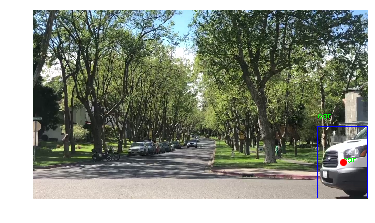

In [150]:
import tensorflow as tf
image = []
#image = cv2.imread('car.jpg')

box_locations = []

frame_num = 10
image = image_list[frame_num]
im_height, im_width = image.shape[0:2]

x_coord = 0
y_coord = 0

with tf.Session() as sess:
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
  # The model expects a 300x300 image as input
    image_scaled = cv2.resize(image, (300, 300))
    
    detections = sess.run([
        sess.graph.get_tensor_by_name('num_detections:0'),    # [0] in detections
        sess.graph.get_tensor_by_name('detection_scores:0'),  # [1] in detections
        sess.graph.get_tensor_by_name('detection_boxes:0'),   # [2] in detections
        sess.graph.get_tensor_by_name('detection_classes:0'), # [3] in detections
        ], feed_dict={'image_tensor:0': image_scaled.reshape(1, image_scaled.shape[0], image_scaled.shape[1], 3)})
  
  # num_detections:0
    detection_count = int(detections[0][0])
    print("Found", detection_count, "objects")
  
    for i in range(1):#range(detection_count):
    #for i in range(3):
    # detection_scores:0
        confidence_score = detections[1][0][i]
    
    # detection_boxes:0
        box = detections[2][0][i]
        box_top = box[0] * im_height
        box_left = box[1] * im_width
        box_bottom = box[2] * im_height
        box_right = box[3] * im_width
        
        
        print(box_left, box_top)
        if not x_coord:
            x_coord = box_left + (box_right - box_left)/2
            y_coord = box_top + (box_bottom - box_top)/2
        #box_locations.append([box_bottom + (box_top - box_bottom), box_left + (box_right - box_left)])

        dist, r,g,b, dot_color = dot_on_image(processed_images[frame_num], x_coord, y_coord)
        
    # detection_classes:0
        label_id = int(detections[3][0][i])
        label_name = labels[label_id]

        print("Found label {} (id {}) with a confidence of {}. Bounding box [top: {}, left: {}, bottom: {}, right: {}]".format(
            label_name, label_id, confidence_score, box_top, box_left, box_bottom, box_right))
        print(x_coord, y_coord)

        #dist, r,g,b = dot_on_image()
        
        #r = 0
        #g = 255
        #b = 0   
        cv2.rectangle(image, (int(box_left), int(box_top)), (int(box_right), int(box_bottom)), (r,g,b), thickness=2)
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (int(x_coord), int(y_coord))#(int(box_left),int(box_top)-30)
        fontScale              = 1
        fontColor              = (0,255,0)
        lineType               = 1

        cv2.putText(image,'car', 
        bottomLeftCornerOfText, 
        font, 
        fontScale,
        fontColor,
        thickness= 2)
    

    
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image, zorder=1)
plt.scatter(x_coord, y_coord, zorder=2, marker = 'o', color = dot_color)
plt.grid(False)
plt.axis('off')
plt.show()

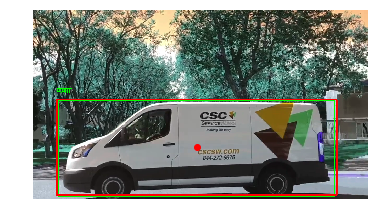

In [138]:

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image, zorder=1)
plt.scatter(x_coord, y_coord, zorder=2, marker = 'o', color = dot_color)
plt.grid(False)
plt.axis('off')
plt.show()

In [30]:
A = processed_images[0]
print(A)

box_location

<PIL.Image.Image image mode=RGBA size=1280x720 at 0x1506F66D8>


[[481.5808868408203, 627.448844909668], [0.0, 0.0], [0.0, 0.0]]